In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.ao.nn.quantized.functional import threshold
from torch.utils.data import DataLoader

from models import Autoencoder
from utils import train_autoencoder, load_mnist

from utils import knn_impute_image, mean_impute_image
from utils import Missingness

In [2]:
train_data, test_data = load_mnist()

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dae = Autoencoder()

optimizer = torch.optim.Adam(dae.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
missingness = Missingness()
# ae.load_state_dict(torch.load('../checkpoints/autoencoder_mnist.pth', map_location=device))

In [4]:
losses = train_autoencoder(
    dae,
    train_loader,
    optimizer,
    loss_fn,
    epochs=2,
    # missingness=missingness,
    # corruption_type='mcar',
    # device=device,
    # missing_rate=0.25,
)

Epoch 1/2: average loss = 0.0604
Epoch 2/2: average loss = 0.0305


In [7]:
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist.pth")

In [13]:
def plot_missingness(train_data, missingness, n_cols=4):
    types = [
        lambda img: missingness.mcar(img, missing_rate=0.25)[0],
        lambda img: missingness.mar(img, alpha=5)[0],
        lambda img: missingness.mnar(img, threshold=0.90, inverse=True)[0],
        lambda img: missingness.block_missing(img, n_blocks=4, min_size=6, max_size=8, missing_rate=0.75)[0],
        lambda img: missingness.row_missing(img, num_rows=5)[0],
        lambda img: missingness.col_missing(img, num_cols=5)[0],
        lambda img: missingness.salt_pepper(img, amount=0.25)[0],
    ]

    n_rows = len(types)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    cmap = plt.cm.gray.copy()
    cmap.set_bad(color='red')

    for i in range(n_cols):
        idx = torch.randint(len(train_data), size=(1,)).item()
        img, _ = train_data[idx]

        for row, missing in enumerate(types):
            axs[row][i].imshow(missing(img).squeeze(), cmap=cmap)
            axs[row][i].axis("off")

    fig.tight_layout()
    plt.show()

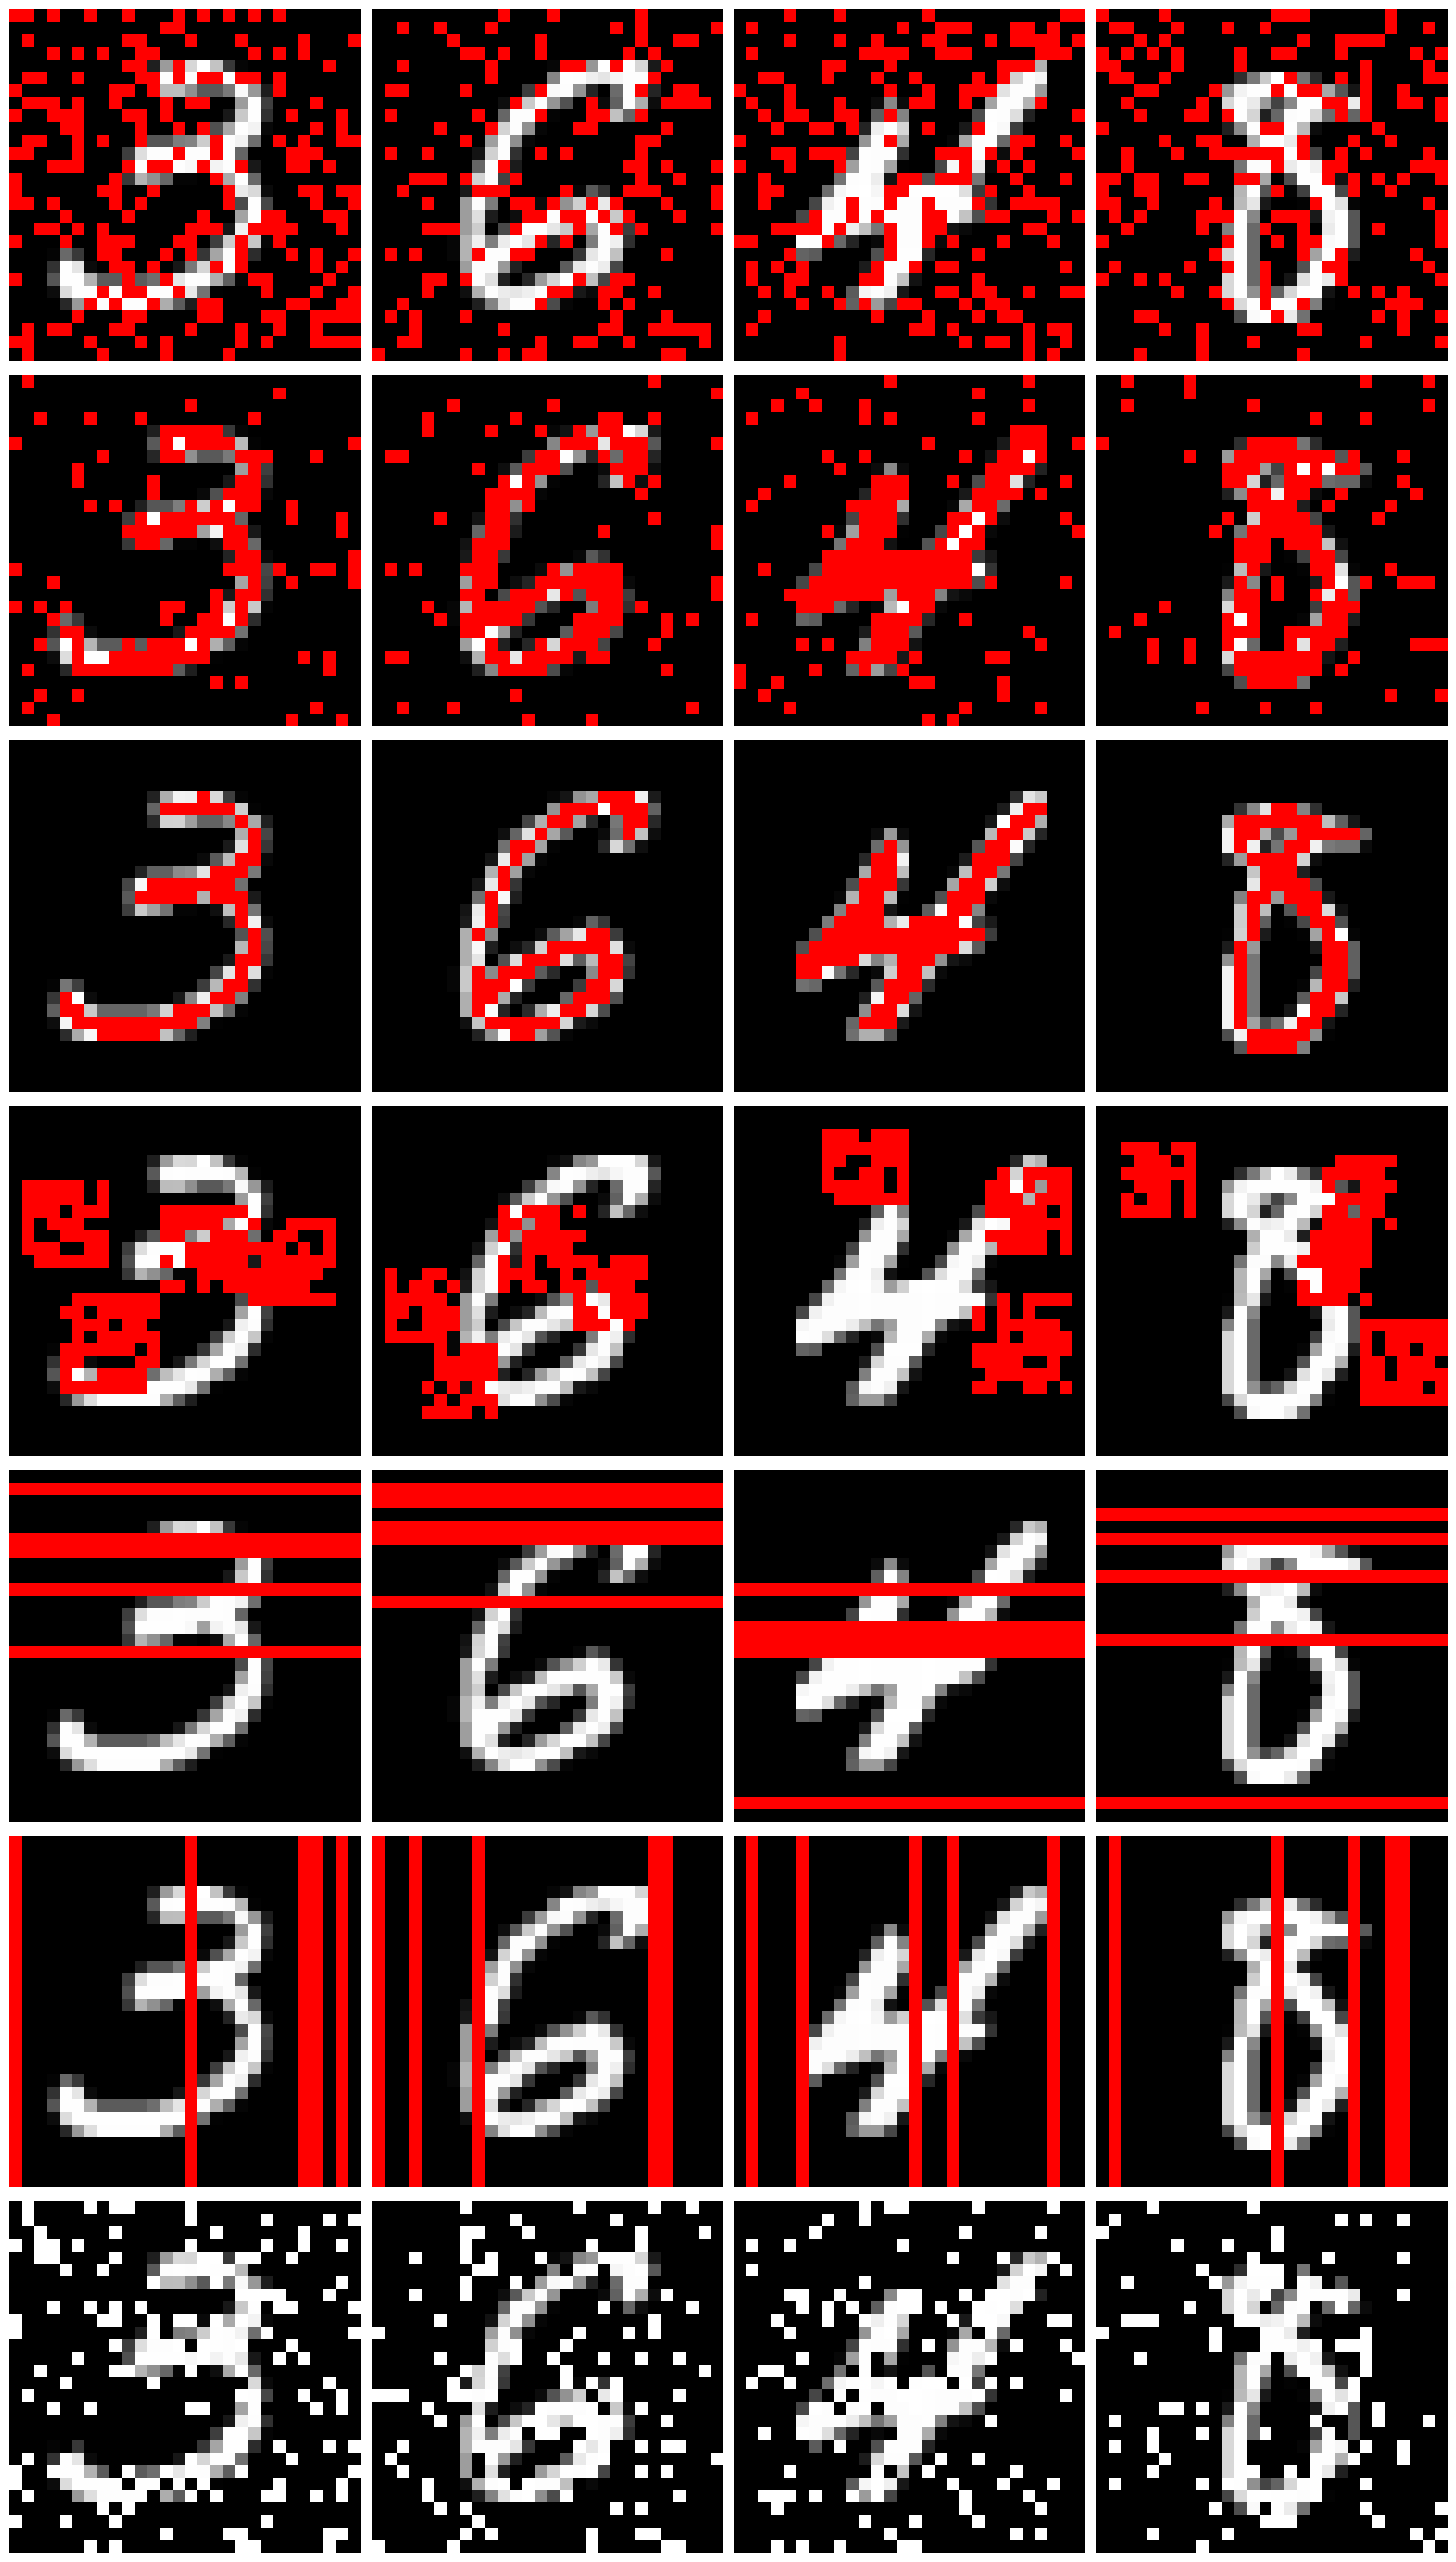

In [14]:
plot_missingness(train_data, missingness)

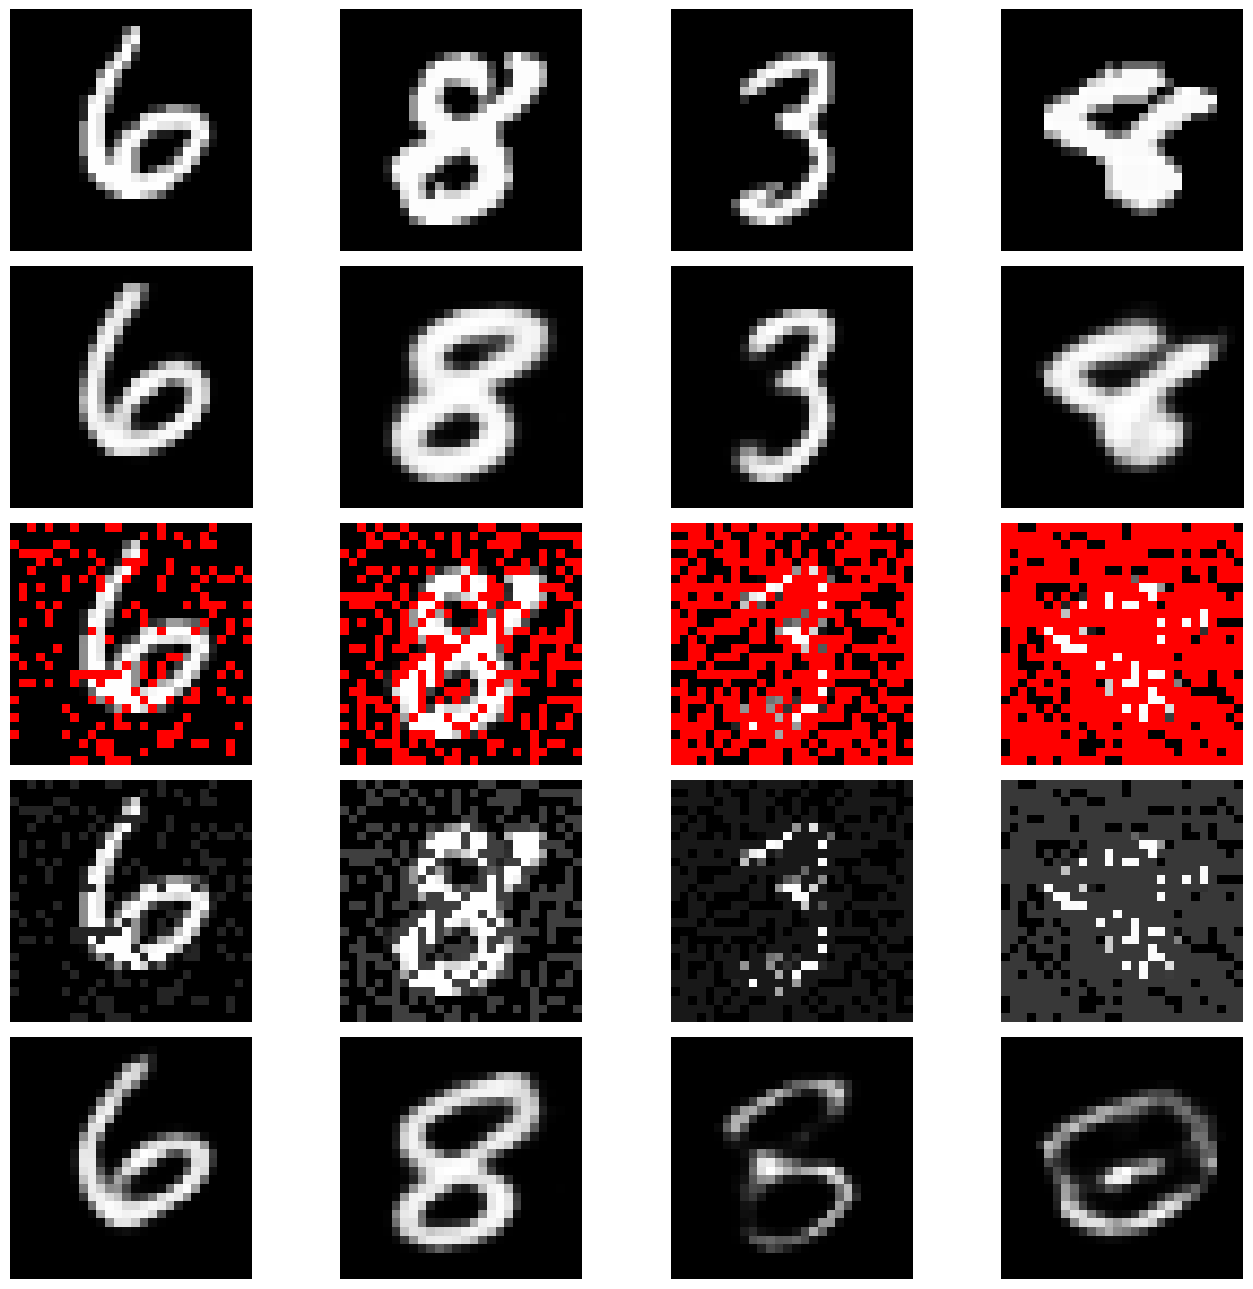

In [29]:
idx = torch.randint(len(train_data), size=(4, 1)).numpy()
ae.eval()

fig, axs = plt.subplots(5, 4, figsize=(14, 13))

for i, index in enumerate(idx):
    img, label = train_data[index.item()]

    masked_img, mask = missingness.mcar(img, missing_rate=(i + 1) * 0.20)
    # masked_img, mask = missingness.mcar(img, missing_rate=(i + 1) * 0.20)
    imputed_img = mean_impute_image(masked_img)
    # imputed_img = knn_impute_image(masked_img)

    img = img.squeeze()

    reconstructed_img, latent = ae(img.view(784).to(device))
    reconstructed_corrupted, corrupted_latent = ae(imputed_img.view(784).to(device))

    axs[0][i].imshow(img, cmap="gray")
    axs[0][i].axis('off')

    axs[1][i].imshow(reconstructed_img.detach().cpu().view(28, 28), cmap="gray")
    axs[1][i].axis('off')

    cmap = plt.cm.gray.copy()
    cmap.set_bad(color='red')

    axs[2][i].imshow(masked_img.view(28, 28), cmap=cmap)
    axs[2][i].axis('off')

    axs[3][i].imshow(imputed_img.squeeze(), cmap="gray")
    axs[3][i].axis('off')

    axs[4][i].imshow(reconstructed_corrupted.detach().cpu().view(28, 28), cmap="gray")
    axs[4][i].axis('off')

fig.tight_layout()
plt.show()